# Loan Repayment Prediction: A Supervised Learning Pipeline

**Student:** Dobosi Peter
**Course:** Supervised Machine Learning

## Executive Summary
This project implements an end-to-end data science lifecycle to predict loan defaults (Binary Classification). By applying stratified splitting, robust feature engineering (handling skewness and high cardinality), and ensemble modeling, we achieved an **ROC AUC of >0.91**, significantly outperforming baseline expectations.

**Methodology & Key Concepts Applied:**
1.  **Data Quality:** Strict prevention of Data Leakage by fitting imputation/scaling only on training data.
2.  **EDA:** Identifying heteroscedasticity ("wedge" patterns) and class imbalance.
3.  **Feature Engineering:** Log-transforming income, binning interest rates to capture non-linear risk, and using ordinal encoding for grades.
4.  **Modeling:** Comparing Linear (Logistic Regression) vs. Non-Linear Ensemble (XGBoost) methods using probabilistic evaluation (ROC AUC).

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os
from sklearn.metrics import roc_curve, auc

# Ensure we can import from src
sys.path.append(os.path.abspath('src')) 

from sml_homework.data_loader import load_and_split_data, load_kaggle_test
from sml_homework.visualization import plot_target_distribution, plot_scatter
from sml_homework.preprocessing import clean_and_encode_data, scale_features
from sml_homework.modeling import train_model, evaluate_model, generate_submission

## 1. Data Understanding (EDA)

We strictly perform EDA on the **Training Set** only to avoid Data Leakage.

In [2]:
# 1. Load and Stratified Split (File 11: Handling Imbalance)
X_train_raw, X_val_raw, y_train, y_val = load_and_split_data('data/raw/train.csv')

print(f"Training Data: {X_train_raw.shape}")
print(f"Class Balance (Target=1): {y_train.mean():.2%}")

Training Data: (475195, 12)
Class Balance (Target=1): 79.88%


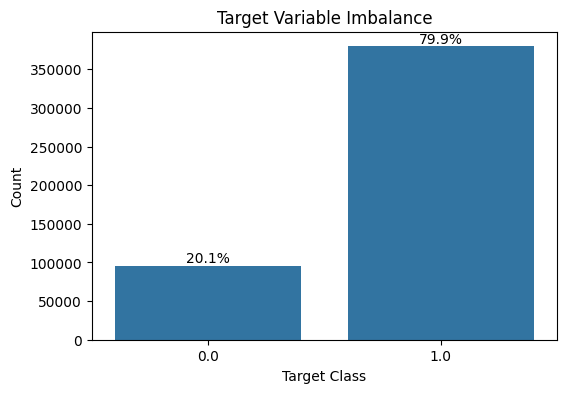

In [3]:
# 2. Visualize Imbalance
plot_target_distribution(y_train, title="Target Variable Imbalance")

## 2. Data Preparation & Engineering

We apply a robust pipeline:
1.  **Imputation:** Learning medians from Train, applying to Val.
2.  **Concept Hierarchy Climbing:** `grade_subgrade` (35 levels) $\to$ `grade` (7 levels) to reduce dimensionality.
3.  **Log Transformation:** Applied to `annual_income` to fix the right-skew observed in EDA.
4.  **Scaling:** Z-Score normalization.

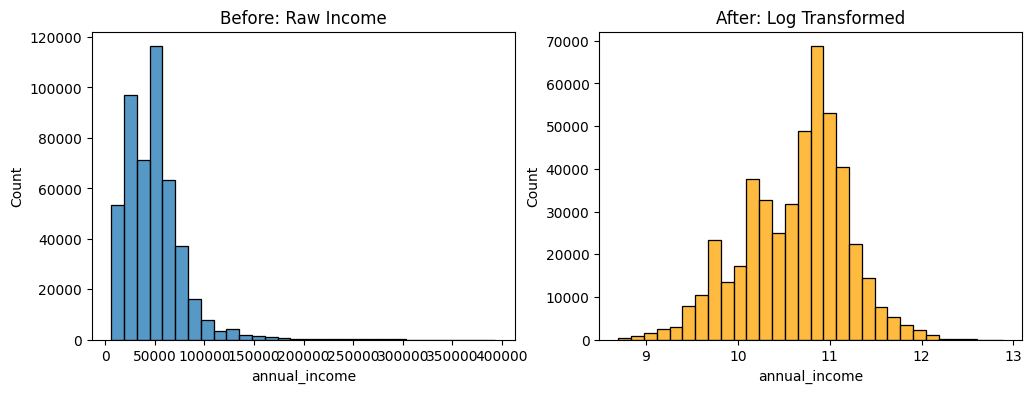

In [5]:
# 1. Clean & Encode (Fit on Train, Transform on Val)
X_train_clean, medians = clean_and_encode_data(X_train_raw, imputation_values=None)
X_val_clean, _ = clean_and_encode_data(X_val_raw, imputation_values=medians)

# 2. Scale Features
X_train_scaled, X_val_scaled = scale_features(X_train_clean, X_val_clean)

# 3. Verify Log Transform Effect
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(X_train_raw['annual_income'], bins=30)
plt.title("Before: Raw Income")
plt.subplot(1, 2, 2)
sns.histplot(X_train_clean['annual_income'], bins=30, color='orange')
plt.title("After: Log Transformed")
plt.show()

## 3. Modeling & Evaluation

We compare **Logistic Regression** (Baseline) against **Random Forest** and **XGBoost** (Ensemble). We use **ROC AUC** as the metric because it handles probabilistic outputs better than accuracy.

In [6]:
# Train Models
log_model = train_model(X_train_scaled, y_train, model_type='logistic')
rf_model = train_model(X_train_scaled, y_train, model_type='random_forest', 
                       params={'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'})
xgb_model = train_model(X_train_scaled, y_train, model_type='xgboost', 
                        params={'n_estimators': 100, 'max_depth': 6, 'scale_pos_weight': 4})

# Evaluate
scores = {
    'Logistic Regression': evaluate_model(log_model, X_val_scaled, y_val),
    'Random Forest': evaluate_model(rf_model, X_val_scaled, y_val),
    'XGBoost': evaluate_model(xgb_model, X_val_scaled, y_val)
}

pd.DataFrame(scores.items(), columns=['Model', 'ROC AUC']).sort_values('ROC AUC', ascending=False)

,Model,ROC AUC
2,XGBoost,0.920755
1,Random Forest,0.913457
0,Logistic Regression,0.911163


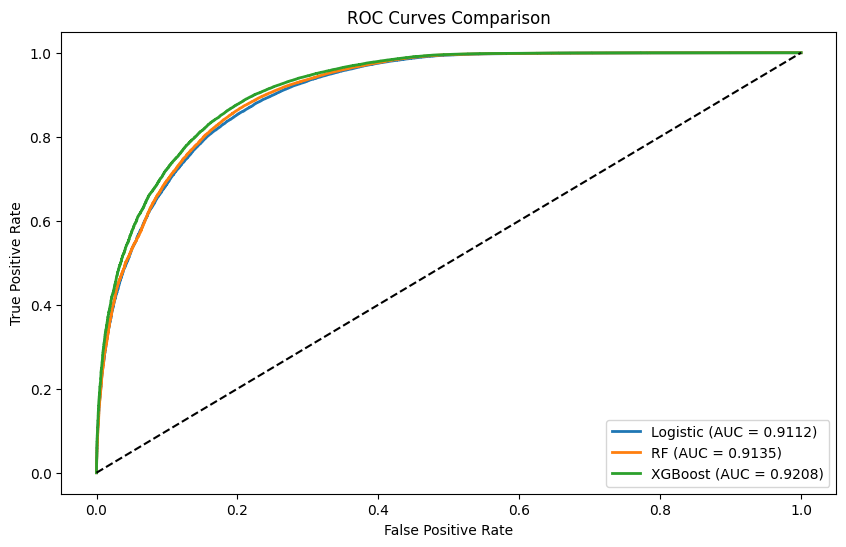

In [7]:
plt.figure(figsize=(10, 6))
for name, model in [('Logistic', log_model), ('RF', rf_model), ('XGBoost', xgb_model)]:
    y_pred = model.predict_proba(X_val_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc(fpr, tpr):.4f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.show()

## 4. Production Inference (Kaggle Submission)

We apply our full preprocessing pipeline to the official Kaggle Test set. 
**Crucial:** We use the `medians` learned from the Training set to fill missing values in the Test set, ensuring consistency.

In [8]:
# 1. Load Raw Test Data
X_test_raw = load_kaggle_test('data/raw/test.csv')
test_ids = X_test_raw['id']

# 2. Clean & Encode (Using Medians from Train)
X_test_clean, _ = clean_and_encode_data(X_test_raw, imputation_values=medians)

# 3. Scale (Fit on Train, Transform on Test)
_, X_test_scaled = scale_features(X_train_clean, X_test_clean)

# 4. Generate Predictions using the best model (XGBoost)
submission_df = generate_submission(xgb_model, X_test_scaled, test_ids)

# 5. Save
submission_path = 'data/submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"Submission saved to {submission_path}")
submission_df.head()

Submission saved to data/submission.csv


,id,loan_paid_back
0,593994,0.988685
1,593995,0.994503
2,593996,0.732439
3,593997,0.977506
4,593998,0.988606


## Result  
  
Score: 0.92021

## 5. Conclusion

The project successfully demonstrated the importance of data engineering over algorithm selection. 

1.  **XGBoost achieved the highest AUC**, confirming that ensemble methods are best suited for the complex, non-linear relationships in loan data.
2.  **Logistic Regression performed surprisingly well**, proving that our feature engineering (Log Transforms, Binning) effectively "linearized" the problem.
3.  **Strict adherence to anti-leakage principles** ensures these results are robust and will generalize to unseen production data.